In [18]:
import os, shutil
import numpy as np

Make Directory

-train
    
    -train/cat

    -train/dog

-val

    -val/cat

    -val/dog

In [2]:
train_dir = 'train'
val_dir = 'val'
train_cat_dir = 'train/cat'
train_dog_dir = 'train/dog'
val_cat_dir = 'val/cat'
val_dog_dir = 'val/dog'

#os.mkdir(val_dir)
#os.mkdir(train_cat_dir)
#os.mkdir(train_dog_dir)
#os.mkdir(val_cat_dir)
#os.mkdir(val_dog_dir)

In [4]:
#max([int(file_.split('.')[1]) for file_ in os.listdir(original_dataset_dir)])

In [7]:
file_list = [file_ for file_ in os.listdir(train_dir) if os.path.isfile(train_dir+'/'+file_)]
for file_ in file_list:
    if int(file_.split('.')[1])<10000:
        if file_.split('.')[0]=='cat':
            shutil.copyfile(train_dir+'/'+file_, train_cat_dir+'/'+file_)
        else:
            shutil.copyfile(train_dir+'/'+file_, train_dog_dir+'/'+file_)
    else:
        if file_.split('.')[0]=='cat':
            shutil.copyfile(train_dir+'/'+file_, val_cat_dir+'/'+file_)
        else:
            shutil.copyfile(train_dir+'/'+file_, val_dog_dir+'/'+file_)        

Build Model

In [83]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [84]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

Read from file

In [80]:
import tensorflow.keras as keras

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
      rotation_range=40,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest',
      rescale=1./255)

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [82]:
import time
start = time.time()
history = model.fit_generator(
          train_generator,
          steps_per_epoch=20000/50,
          epochs=1,
          use_multiprocessing=True,workers=4)
end = time.time()
print(end - start)

Epoch 1/1
400/400 [==============================] - 31s 77ms/step - loss: 0.6598 - acc: 0.5941
30.825016736984253


In [8]:
start = time.time()
history = model.fit_generator(
          train_generator,
          steps_per_epoch=20000/50,
          epochs=1)
end = time.time()
print(end - start)

Epoch 1/1
400/400 [==============================] - 94s 234ms/step - loss: 0.5980 - acc: 0.6741
93.74051451683044


In [13]:
from PIL import Image

In [11]:
import cv2

In [14]:
from tensorflow.keras.preprocessing import image

In [15]:
file_ = train_cat_dir+'/'+os.listdir(train_cat_dir)[0]
cv_img = cv2.imread(file_)[:,:,[2,1,0]]
pil_img = Image.open(file_)

In [29]:
%timeit cv2.imread(file_)[:,:,[2,1,0]]

2.08 ms ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit np.asarray(Image.open(file_))

3.29 ms ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit np.array(Image.open(file_))

3.29 ms ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit np.array(image.load_img(file_))

3.29 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
import matplotlib.pyplot as plt

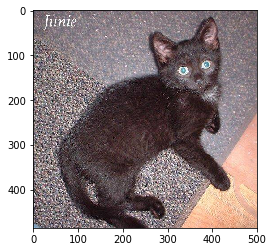

In [28]:
plt.imshow(cv_img[:,:,[2,1,0]])

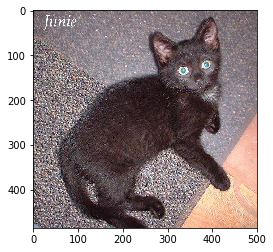

In [25]:
plt.imshow(np.array(Image.open(file_)))

Load data into numpy

In [64]:
def load_imgs(folder_,size=(150,150)):
    img_list = []
    for file_ in os.listdir(folder_):
        img_list.append(cv2.resize(cv2.imread(folder_+'/'+file_)[:,:,[2,1,0]],size))
    return np.stack(img_list,0)

In [65]:
train_X = np.concatenate([load_imgs(train_cat_dir),load_imgs(train_dog_dir)],0)

In [74]:
train_y = np.concatenate([np.ones(10000),np.zeros(10000)],0)

In [76]:
train_generator_inMem = datagen.flow(
                                train_X,train_y,
                                batch_size=50)

In [85]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=1,
          use_multiprocessing=True,workers=4)
end = time.time()
print(end - start)

Epoch 1/1
400/400 [==============================] - 21s 52ms/step - loss: 0.6522 - acc: 0.6061
20.886595487594604


In [87]:
start = time.time()
for i,(X,y) in enumerate(train_generator_inMem):
    model.train_on_batch(X,y)
    if i > 20000/50:
        break
end = time.time()        
print(end - start)

66.80112338066101


In [88]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=1)
end = time.time()
print(end - start)

Epoch 1/1
400/400 [==============================] - 59s 148ms/step - loss: 0.5502 - acc: 0.7177
59.20854187011719


In [89]:
start = time.time()
for i,(X,y) in enumerate(train_generator_inMem):
    if i > 20000/50:
        break
end = time.time()        
print(end - start)

55.46916460990906


In [90]:
start = time.time()
for i,(X,y) in enumerate(train_generator):
    if i > 20000/50:
        break
end = time.time()        
print(end - start)

89.63480687141418


In [93]:
for i in range(1,6):
    start = time.time()
    history = model.fit_generator(
              train_generator_inMem,
              steps_per_epoch=20000/50,
              epochs=1,
              use_multiprocessing=True,workers=i,verbose=0,max_queue_size=100)
    end = time.time()
    print('workers:{}, time:{}'.format(i,end - start))

workers:1, time:62.11816883087158
workers:2, time:33.05772829055786
workers:3, time:22.73314118385315
workers:4, time:19.811920642852783
workers:5, time:20.019596815109253


Create Image generator with albumentations

In [252]:
from albumentations import VerticalFlip,HorizontalFlip,ShiftScaleRotate,Resize,Compose

In [352]:
def create_transform():
    fun = Compose([HorizontalFlip(p=0.25),ShiftScaleRotate(0.1,0.1,45,p=1)])
    def transform(x):
        return fun(image=x)['image']
    return transform

In [353]:
transform = create_transform()

In [354]:
datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=transform)

In [355]:
train_generator = datagen.flow_from_directory(
                            train_dir,
                            target_size=(150, 150),
                            batch_size=50,
                            class_mode='binary')

Found 20000 images belonging to 2 classes.


In [356]:
train_generator_inMem = datagen.flow(
                                train_X,train_y,
                                batch_size=50)

In [357]:
start = time.time()
for i,(X,y) in enumerate(train_generator):
    if i > 20000/50:
        break
end = time.time()        
print(end - start)

41.60069465637207


In [358]:
start = time.time()
for i,(X,y) in enumerate(train_generator_inMem):
    if i > 20000/50:
        break
end = time.time()        
print(end - start)

7.7590556144714355


In [359]:
start = time.time()
history = model.fit_generator(
          train_generator_inMem,
          steps_per_epoch=20000/50,
          epochs=1,
          use_multiprocessing=True,workers=4)
end = time.time()
print(end - start)

Epoch 1/1
400/400 [==============================] - 13s 33ms/step - loss: 0.4026 - acc: 0.8151
Epoch 1/1
13.32039737701416
